In [1]:
''' 1, Module Import '''
import numpy as np 
import matplotlib.pyplot as plt # 시각화 외부 모듈
import torch
import torch.nn as nn # 딥러닝 설계에 필요한 함수만 모아둔 파이토치 모듈
import torch.nn.functional as F 
from torchvision import transforms, datasets # 컴퓨터 비전 연구 분야에서 자주 이용하는 torchvision 모듈

In [2]:
''' 2. 딥러닝 모델 설계시 활용하는 장비 확인 '''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version: ', torch.__version__, '| Device : ', DEVICE)

Using PyTorch version:  1.7.0+cu101 | Device :  cuda


In [3]:
BATCH_SIZE = 32 # MLP 모델 학습에서 필요한 데이터의 단위. 전체 데이터에서 32개의 데이터를 추출하여 학습함
EPOCHS = 10

'''
32개의 데이터로 1개의 Mini-Batch를 구성하고, 1개의 Mini-Batch로 학습을 1회 진행한다. 
1개의 Mini-Batch를 이용해 학습하는 횟수를 'Iteration', 전체 데이터를 이용해 학습을 진행한 횟수를 'Epoch'이라 한다.
쉽게 말하면 'Epoch'은 존재하고 있는 Mini-batch를 전부 이용하는 횟수를 의미하는 것!
한 번의 Epoch을 위해 여러번의 iteration이 필요하다. 
여기서는 전체 데이터 셋을 10번 반복해 학습하도록 설정했다.

예를들어, 전체 데이터가 1만 개이고 1,000개의 데이터를 이용해 1개의 Mini-Batch를 구성한다면 1Epoch당 10회의 Iteration이 발생한다. 
'''

"\n32개의 데이터로 1개의 Mini-Batch를 구성하고, 1개의 Mini-Batch로 학습을 1회 진행한다. \n1개의 Mini-Batch를 이용해 학습하는 횟수를 'Iteration', 전체 데이터를 이용해 학습을 진행한 횟수를 'Epoch'이라 한다.\n쉽게 말하면 'Epoch'은 존재하고 있는 Mini-batch를 전부 이용하는 횟수를 의미하는 것!\n한 번의 Epoch을 위해 여러번의 iteration이 필요하다. \n여기서는 전체 데이터 셋을 10번 반복해 학습하도록 설정했다.\n\n예를들어, 전체 데이터가 1만 개이고 1,000개의 데이터를 이용해 1개의 Mini-Batch를 구성한다면 1Epoch당 10회의 Iteration이 발생한다. \n"

In [4]:
''' 3. MNIST 데이터 다운로드 & Train/Test 셋 분리하기 '''

# root : 데이터가 저장될 장소
# train : 대상 데이터가 MLP 모델을 학습하기 위해 이용하는 학습용 데이터인지 판단. True = 학습용 데이터, False = 검증용 데이터
# download : 인터넷상에서 다운로드하여 사용할 것인지 결정
# transform : MNIST 데이터는 이미지 데이터이다. 데이터를 다운로드 할 때 ToTensor() 메서드를 이용하여 tensor 형태로 변경
# 하고 0~255 범위의 스칼라 값으로 구성된 픽셀을 0~1 범위에서 정규화 과정 진행

train_dataset = datasets.MNIST(root = "../data/MNIST", train = True, download = True, transform = transforms.ToTensor())
test_dataset = datasets.MNIST(root = "../data/MNIST", train = False, transform = transforms.ToTensor())

# DataLoader 함수를 이용해 배치 사이즈만큼 묶어 하나의 Mini-Batch 구성
# dataset : 미니배치 단위로 할당하고자 하는 데이터셋 지정
# batch_size : 미니배치 1개 단위를 구성하는 데이터의 개수
# shuffle : 데이터의 순서를 섞거나(True) 섞지 않거나(False)

train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

0it [00:00, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw


0it [00:00, ?it/s]

Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw
Processing...
Done!


/home/ubuntu/anaconda3/lib/python3.6/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
''' 4. 데이터 확인하기 '''
# 미니배치 단위로 할당한 데이터의 개수와 형태 확인
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:',X_train.type()) # (32,1,28,28)
    # 가로 28개, 세로 28개의 픽셀로 구성된 이미지 32개가 모여있고, 채널이 1이므로 그레이스케일(흑백)로 이뤄진 이미지 데이터 셋
    
    print('y_train:',y_train.size(), 'type:', y_train.type()) # 레이블 값
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


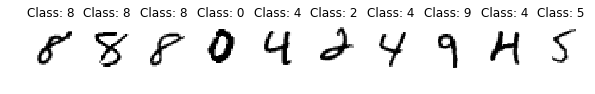

In [6]:
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap = "gray_r")
    plt.title('Class: ' + str(y_train[i].item()))

In [7]:
''' 5. MLP 모델 설계하기'''
class Net(nn.Module): # torch 모듈 내 딥러닝 관련 기본 함수를 포함하고 있는 클래스를 상속받는 Net 클래스 정의
    def __init__(self): # Net 클래스의 인스턴스 생성시 지니게 되는 성질 정의
        super(Net, self).__init__() # nn.Module 내에 있는 메서드를 상속받아 이용
        # 첫 번째 Fully Connected Layer
        # MNIST 데이터를 innput으로 받기 때문에 28 * 28 * 1(가로 픽셀 * 세로 픽셀 * 채널 수)크기의 노드 수를 설정. 
        self.fc1 = nn.Linear(28 * 28, 512)
        # 두 번째 Fully Connected Layer
        self.fc2 = nn.Linear(512,256)
        # 세 번째 Fully Connected Layer
        # 0부터 9까지 총 10가지 클래스를 표현하기 위한 Label 값은 원-핫 인코딩으로 표현됨
        self.fc3 = nn.Linear(256, 10)
        
        self.dropout_prob = 0.5 # Dropout, 몇 퍼센트의 노드에 대해 가중값을 계산하지 않을 것인지 명시
        self.batch_norm1 = nn.BatchNorm1d(512) # 배치 정규화. 첫 번째 Fully Connected Layer의 Output이 512 크기의 벡터 값
        self.batch_norm2 = nn.BatchNorm1d(256) # 배치 정규화. 두 번째 Fully Connected Layer의 Output이 256 크기의 벡터 값
        
    def forward(self, x): # Forward Propagation 정의
        x = x.view(-1, 28 * 28) # view 메서드를 이용하여 2차원 데이터(크기가 28 * 28인)를 1차원 데이터로 변환
        x = self.fc1(x) # 첫 번째 Layer 통과
        x = self.batch_norm1(x) # 배치 정규화
        x = F.relu(x) # 활성화 함수 적용
        x = F.dropout(x, training = self.training, p = self.dropout_prob) # dropout
        x = self.fc2(x) # 두 번째 Layer 통과
        x = self.batch_norm2(x) # 배치 정규화
        x = F.relu(x) # 활성화 함수 적용
        x = F.dropout(x, training = self.training, p = self.dropout_prob) # dropout
        x = self.fc3(x) # 세 번째 Layer 통과
        x = F.log_softmax(x, dim = 1) # 출력층 활성화 함수 적용. softmax 함수를 이용해 확률 값을 계산함.
        # Loss 값에 대한 Gradient 값을 좀 더 원활하게 계산할 수 있도록 log_softmax적용
        # 최종 계산된 x 값을 Output으로 반환
        return x 

In [8]:
''' 6. Optimizer, Objective Function 설정하기'''
import torch.nn.init as init # 딥러닝 모델에서 초깃값(Weight, bias 등)으로 설정되는 요소에 대한 모듈
def weight_init(m) :
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data) # he_initialization을 이용한 파라미터 초기화
        
model = Net().to(DEVICE) # MLP 모델을 기존에 선정한 'DEVICE'에 할당
model.apply(weight_init) # MLP 모델에 he_initialization 적용
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5) # 파라미터 업데이트 시 이용하는 optimizer는 SGD로 정의
criterion = nn.CrossEntropyLoss() # 평가 기준은 CrossEntropyLoss() 

# Cross EntropyLoss() : 손실함수. 교차 엔트로피 오차
# MLP 모델의 output 값과 계산될 Label 값은 Class를 표현하는 원-핫 인코딩 값

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [9]:
''' 7. MLP 모델 학습 진행 & 학습 데이터에 대한 모델 성능을 확인하는 함수 정의 '''
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE) # Mini-Batch 내에 있는 이미지 데이터를 기존에 정의한 장비에 할당
        label = label.to(DEVICE) # Mini-Batch 내에 있는 이미지 데이터의 레이블 데이터를 기존에 정의한 장비에 할당
        optimizer.zero_grad() # optimizer의 Gradient 초기화
        output = model(image) # 장비에 할당한 이미지 데이터를 MLP 모델의 input으로 활용해 output 계산
        loss = criterion(output, label) # Loss 계산
        loss.backward() # Loss 값을 계산한 결과를 바탕으로 Back Propagation을 통해 계산된 Gradeint 값을 각 파라미터에 할당
        optimizer.step() # 각 파라미터에 할당된 Gradeint 값을 이용해 파라미터 값을 업데이트
        
        if batch_idx % log_interval == 0: # 학습 진행 과정 확인
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}".format(
            Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))

In [10]:
''' 8. 검증 데이터에 대한 모델의 성능을 확인'''
def evaluate(model, test_loader):
    model.eval() # 학습 과정이 완료된 MLP 모델을 평가 상태로 지정
    test_loss = 0 
    correct = 0
    
    with torch.no_grad(): # Gradient 흐름 억제
        for image, label in test_loader: # 기존에 정의한 test_loader 내의 데이터에 접근
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            # output과 레이블 데이터의 교차 엔트로피 오차를 구하여 loss를 계산하고 그 결괏값을 test_loss에 더함
            test_loss += criterion(output, label).item()
            
            # 계산된 벡터 값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단
            prediction = output.max(1, keepdim = True)[1]
            
            # MLP 모델이 예측한 값과 실제 레이블이 의미하는 클레스가 맞으면 correct에 더함
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    # (현재까지 계산된 test_loss) / (test_loader의 전체 데이터 갯수)        
    test_loss /= len(test_loader.dataset) # 평균 loss 계산
    
    # 정확도 계산
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

In [11]:
''' 9. MLP 학습을 실행하면서 Train, Test set의 Loss 및 Test set Accuracy 확인 '''
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200) # 진행상황 확인하는 주기는 200
    test_loss, test_accuracy = evaluate(model,test_loader)
    print("\n[EPOCH : {}], \tTest Loss: {:.4f}, \tTes Accuracy: {:.2f} %\n".format(Epoch, test_loss, test_accuracy))

Train Epoch: 1 [0/60000 (0%)]	Train Loss: 2.830961
Train Epoch: 1 [6400/60000 (11%)]	Train Loss: 1.205610
Train Epoch: 1 [12800/60000 (21%)]	Train Loss: 0.803917
Train Epoch: 1 [19200/60000 (32%)]	Train Loss: 0.547920
Train Epoch: 1 [25600/60000 (43%)]	Train Loss: 0.489910
Train Epoch: 1 [32000/60000 (53%)]	Train Loss: 0.406093
Train Epoch: 1 [38400/60000 (64%)]	Train Loss: 0.520119
Train Epoch: 1 [44800/60000 (75%)]	Train Loss: 0.426548
Train Epoch: 1 [51200/60000 (85%)]	Train Loss: 0.551491
Train Epoch: 1 [57600/60000 (96%)]	Train Loss: 0.241219

[EPOCH : 1], 	Test Loss: 0.0069, 	Tes Accuracy: 93.46 %

Train Epoch: 2 [0/60000 (0%)]	Train Loss: 0.464202
Train Epoch: 2 [6400/60000 (11%)]	Train Loss: 0.260982
Train Epoch: 2 [12800/60000 (21%)]	Train Loss: 0.255910
Train Epoch: 2 [19200/60000 (32%)]	Train Loss: 0.213979
Train Epoch: 2 [25600/60000 (43%)]	Train Loss: 0.376849
Train Epoch: 2 [32000/60000 (53%)]	Train Loss: 0.253737
Train Epoch: 2 [38400/60000 (64%)]	Train Loss: 0.193884
Tr